# Gradient boosting regression models

The custom class SeasonalGBRX from `tsgbr.py` used here is a child class of `sklearn.ensemble.GradientBoostingRegressor`, inheriting everything from this class. It extends this class with several attributes and methods for easy-to-use modeling and forecasting of time series with gradient boosting regression models. It requires as input and returns as output pandas series with PeriodIndex. 

Gradient boosting regression models can model the seasonality of a time series in a relatively flexible fashion by generating an array with time sequences for each frequency provided (e.g. integers from 1 to 12 for each year in the series).

### References

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

## Imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from forecasttk.gbr import SeasonalGBRX
import forecasttk.visualize as viz
from forecasttk.evaluate import eval_model 

plt.style.use("seaborn-whitegrid")

## Load and prepare data

In [16]:
# Load data
df = pd.read_csv("data/catalog_seasfac.csv",
                 usecols=["date", "men", "women", "jewel", "mail", "page", "phone", "print", "service"],
                 index_col = "date")

# Convert index to PeriodIndex
df.index = pd.to_datetime(df.index).to_period("M")

# Define features and target
y = df["women"]
X = df[["mail", "page", "phone", "print", "service"]]

# Show features and target
X.join(y).head()

,mail,page,phone,print,service,women
date,,,,,,
1989-01,7978,73,34,22294.48,20,16578.93
1989-02,8290,88,29,27426.47,20,18236.13
1989-03,8029,65,24,27978.66,26,43393.55
1989-04,7752,85,20,28949.65,22,30908.49
1989-05,8685,74,17,22642.27,21,28701.58


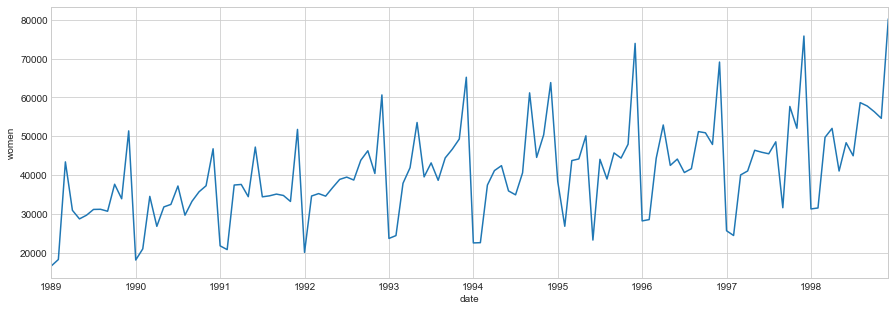

In [17]:
# Visualize target
viz.plot_series(y, xlabel=y.index.name, ylabel=y.name)

## Train/test split

In [18]:
X_train = X[:"1997"]
y_train = y[:"1997"]
X_test = X["1998"]
y_test = y["1998"]

## Univariate Gradient Boosting Regression model

>> TRAINING DATA
Mean of true values:          39477.2528
Mean of predicted values:     39477.2528
Mean absolute error:          2815.3108
Mean relative error:          0.0713
Root mean squared error:      4239.9406
Coefficient of determination: 0.8658
>> TEST DATA
Mean of true values:          50541.5242
Mean of predicted values:     44535.4226
Mean absolute error:          6595.7527
Mean relative error:          0.1305
Root mean squared error:      7558.0697
Coefficient of determination: 0.6418


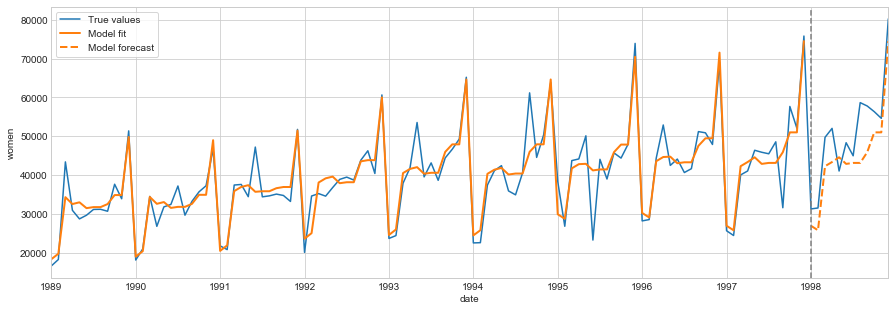

In [19]:
# Instantiate model with yearly, quarterly and monthly seasonality
model = SeasonalGBRX(y=y_train, max_depth=2, n_estimators=100, frequencies=["year", "quarter", "month"])

# Train model
model = model.fit_ts()

# Predict and forecast
y_pred = model.predict_ts()
y_fcst = model.forecast_ts(12)

# Evaluate model on training set
print(">> TRAINING DATA")
eval_model(y_train, y_pred)

# Evaluate model on test set
print(">> TEST DATA")
eval_model(y_test, y_fcst)

# Visualize fit and forecast
viz.plot_model(y, y_pred, y_fcst, xlabel=y.index.name, ylabel=y.name)

In [20]:
# Show generated dataframe of frequencies and time sequences
model.X_endog.head(5)

,year,quarter,month
date,,,
1989-01,1989,1,1
1989-02,1989,1,2
1989-03,1989,1,3
1989-04,1989,2,4
1989-05,1989,2,5


In [21]:
# Feature importances
print(dict(zip(model.frequencies, [round(fi, 4) for fi in model.feature_importances_])))

{'year': 0.2577, 'quarter': 0.0047, 'month': 0.7377}


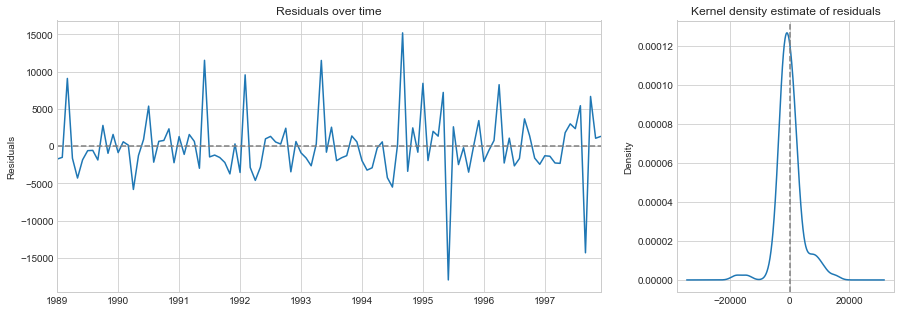

In [23]:
# Plot residuals
viz.plot_residuals(y_train-y_pred)

### Training with staged prediction

This method fits a gradient boosting regression model to the target using staged prediction over all 'n_estimators' and stores the model with the lowest RMSE in a test set. This avoids overfitting.

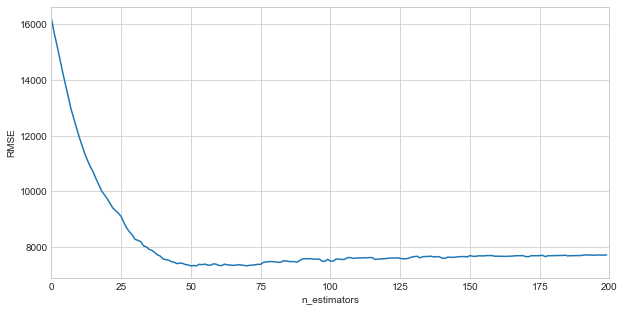

In [24]:
# Instantiate model with yearly, quarterly and monthly seasonality
model = SeasonalGBRX(y=y_train, max_depth=2, frequencies=["year", "quarter", "month"])

# Train model
model = model.fit_ts_with_staged_predict(y_test=y_test, n_estimators=200)

# Show RMSE for each n_estimator
model.plot_n_estimators()

In [25]:
# n_estimators with lowest RMSE on test set
model.n_estimators

50

>> TRAINING DATA
Mean of true values:          39477.2528
Mean of predicted values:     39477.2528
Mean absolute error:          3026.3186
Mean relative error:          0.0767
Root mean squared error:      4479.4736
Coefficient of determination: 0.8502
>> TEST DATA
Mean of true values:          50541.5242
Mean of predicted values:     44585.1910
Mean absolute error:          6347.6044
Mean relative error:          0.1256
Root mean squared error:      7353.9132
Coefficient of determination: 0.6609


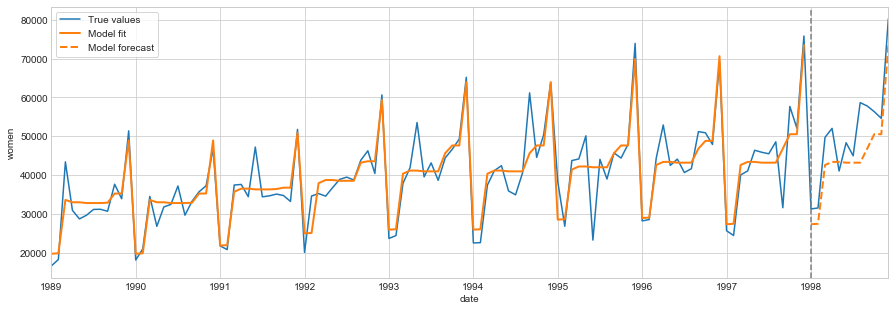

In [26]:
# Predict and forecast
y_pred = model.predict_ts()
y_fcst = model.forecast_ts(12)

# Evaluate model on training set
print(">> TRAINING DATA")
eval_model(y_train, y_pred)

# Evaluate model on test set
print(">> TEST DATA")
eval_model(y_test, y_fcst)

# Visualize fit and forecast
viz.plot_model(y, y_pred, y_fcst, xlabel=y.index.name, ylabel=y.name)